<a href="https://colab.research.google.com/github/PranavkrishnaVadhyar/FirstAidPro/blob/main/FirstAidPro_WoundTypeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
import os
import shutil

# Define the path to your dataset directory
dataset_directory = "/content/drive/MyDrive/Wounds-Types"

# Define the path to your output directory where the organized dataset will be stored
output_directory = "/content/data/Wounds"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# List all subdirectories in the dataset directory (each subdirectory represents a class)
class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

# Iterate through each class directory
for class_dir in class_directories:
    # Create a directory with the same class name in the output directory
    output_class_dir = os.path.join(output_directory, class_dir)
    os.makedirs(output_class_dir, exist_ok=True)

    # List all files in the class directory (these are the images)
    image_files = [f for f in os.listdir(os.path.join(dataset_directory, class_dir)) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Copy each image to the corresponding class directory in the output directory
    for image_file in image_files:
        src_path = os.path.join(dataset_directory, class_dir, image_file)
        dst_path = os.path.join(output_class_dir, image_file)
        shutil.copy(src_path, dst_path)

print("Dataset preparation completed.")


Dataset preparation completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset directory and parameters
dataset_directory = '/content/data/Wounds'
batch_size = 32
image_size = (224, 224)
num_classes = len(os.listdir(dataset_directory))

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for training set
train_generator = train_datagen.flow_from_directory(
    dataset_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True
)

# Data generator for testing set (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    dataset_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False
)


Found 434 images belonging to 4 classes.
Found 434 images belonging to 4 classes.


#ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)  # Add more layers if needed
output = Dense(num_classes, activation='softmax')(x)  # Adjust for the number of classes

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 50  # Adjust the number of training epochs

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Print messages about early stopping
    restore_best_weights=True  # Restore the best model weights
)

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[early_stopping],  # Add early stopping callback
    batch_size=4
)


Epoch 1/50
14/14 [==============================] - 198s 14s/step - loss: 1.6656 - accuracy: 0.2604 - val_loss: 1.3433 - val_accuracy: 0.3479
Epoch 2/50
14/14 [==============================] - 188s 14s/step - loss: 1.4690 - accuracy: 0.2627 - val_loss: 1.4446 - val_accuracy: 0.2650
Epoch 3/50
14/14 [==============================] - 197s 15s/step - loss: 1.4453 - accuracy: 0.3249 - val_loss: 1.4004 - val_accuracy: 0.3479
Epoch 4/50
14/14 [==============================] - 239s 18s/step - loss: 1.3967 - accuracy: 0.2995 - val_loss: 1.4095 - val_accuracy: 0.3548
Epoch 4: early stopping


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities on the test set
y_probs = model.predict(test_generator)

# Convert probabilities to class predictions
y_preds = np.argmax(y_probs, axis=1)

# Get true labels
y_true = test_generator.classes

# Calculate classification metrics
print("Classification Report:")
print(classification_report(y_true, y_preds))

print("Accuracy:", accuracy_score(y_true, y_preds))

print("F1 Score:", f1_score(y_true, y_preds, average='macro'))

# Calculate ROC AUC score
print("ROC AUC Score:", roc_auc_score(y_true, y_probs, multi_class='ovr'))



14/14 [==============================] - 93s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       121
           1       0.35      1.00      0.52       151
           2       0.00      0.00      0.00        75
           3       0.00      0.00      0.00        87

    accuracy                           0.35       434
   macro avg       0.09      0.25      0.13       434
weighted avg       0.12      0.35      0.18       434

Accuracy: 0.347926267281106
F1 Score: 0.12905982905982907
ROC AUC Score: 0.5780292724937864


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


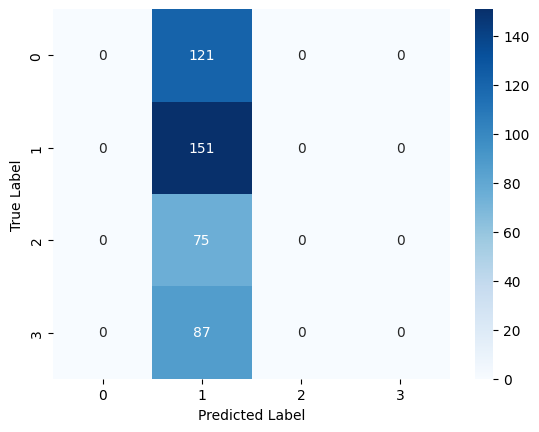

In [ ]:
# prompt: Now write the code for finding the confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(y_true, y_preds)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# prompt: Write the code for a confusion matrix in justtext format

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[  0 121   0   0]
 [  0 151   0   0]
 [  0  75   0   0]
 [  0  87   0   0]]


In [ ]:


model.save('model2.h5')
